# Load relevant libraries

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
#@title Import { display-mode: "form" }
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow.keras.backend as K

tfkl = tf.keras.layers

In [ ]:
tf.__version__

'2.3.0'

## Load data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

bands = np.load("/content/drive/My Drive/image.npy")
print (bands.shape)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(321, 293, 500)


## Preprocessing

In [11]:
def preprocess(images):
  nbands, rows, cols = images.shape

  images = images.reshape(nbands, rows*cols).transpose(1,0)

  images_transformed = MinMaxScaler().fit_transform(images)

  return images_transformed

In [13]:
data = preprocess(bands)

## Network Architecture

In [14]:
class Sampling(tf.keras.layers.Layer):
  def call(self,inputs):
    mean,logvar = inputs
    return K.random_normal(tf.shape(logvar)) * K.exp(logvar/2) + mean


class Encoder(tf.keras.layers.Layer):

  def __init__(self,
               latent_dim=3,
               #initializer = tf.keras.initializers.LecunNormal()
               ):
    super(Encoder, self).__init__()
    self.dropout= layer = tfkl.Dropout(.4)
    self.encode1 = tfkl.Dense(150, activation='selu')
    self.encode2 = tfkl.Dense(100, activation='selu')

    self.dense_mean = tfkl.Dense(latent_dim)
    self.dense_log_var = tfkl.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dropout(inputs)
    x = self.encode1(x)
    x = self.encode2(x)

    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

  def __init__(self,
               reconstructed_shape,
               ):
    super(Decoder, self).__init__()
    self.decode1 = tfkl.Dense(100, activation='selu')
    self.decode2 = tfkl.Dense(150, activation='selu')

    self.reconstructed = tfkl.Dense(reconstructed_shape, activation='sigmoid')

  def call(self, inputs):
    x = self.decode1(inputs)
    x = self.decode2(x)
    x_reconstructed = self.reconstructed(x)

    return x_reconstructed


class CVAE(tf.keras.Model):

  def __init__(self,
               reconstructed_shape,
               latent_dim=3,
               
               ):
    super(CVAE, self).__init__()
    self.reconstructed_shape = reconstructed_shape
    self.encoder = Encoder(latent_dim=latent_dim)
    self.decoder = Decoder(reconstructed_shape)


  def call(self, inputs):
    # self._set_inputs(inputs)
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss/1000.)
    return reconstructed

  def embed(self, inputs):
    _, _, z = self.encoder(inputs)
    z_numpy = z.numpy()
    return z_numpy


## Initialize the model + Callbacks

In [ ]:
reconstructed_shape = 321
variational_autoencoder = CVAE(reconstructed_shape, 3)  #, input_shape=(321,)
epochs = 2
batch_size =32
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
callbacks =[reduce_lr,early_stopping]
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

## Encoding / Decoding

In [ ]:
encoding_mu , encoding_logvar,codings = Encoder().call(data)
reconstructed_inputs = Decoder(reconstructed_shape=321).call(codings)

## Training

##### Losses

Use KL Divergence (integrated in the model class) + Binary cross entropy (it may be interesting to see the impact of their combinations with other loss:

KL-Divergence:
$$
\mathscr{L}=-\frac{1}{2} \sum_{i=1}^{K} 1+\log \left(\sigma_{i}^{2}\right)-\sigma_{i}^{2}-\mu_{i}^{2}
$$

In [ ]:
#latent_loss = -0.5*K.sum(
#    1+ encoding_logvar - K.exp(encoding_logvar) - K.square(encoding_mu),axis=-1)

reconstruction_loss = tf.reduce_mean(tf.square(data - reconstructed_inputs ))
#variational_autoencoder.add_loss(lambda: K.mean(reconstruction_loss)/5000.)

variational_autoencoder.compile(loss="binary_crossentropy",optimizer=adam)
history = variational_autoencoder.fit(data,data,epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/2
4579/4579 [==============================] - 14s 3ms/step - loss: 0.6182
Epoch 2/2
4579/4579 [==============================] - 14s 3ms/step - loss: 0.6151


## Visualization

In [ ]:
embedding = variational_autoencoder.embed(data)


### View distribution of Z over RGB Distribution to estim

In [ ]:
def rgb_mapping(latent_data):

    rgb_space = np.empty_like(latent_data)
    ## Extract min and max of every dimension
    Hmin1 ,Hmax1 = np.min(latent_data[:,0]) ,np.max(latent_data[:,0])
    Hmin2 ,Hmax2 = np.min(latent_data[:,1]) ,np.max(latent_data[:,1])
    Hmin3 ,Hmax3 = np.min(latent_data[:,2])  ,np.max(latent_data[:,2])

    ## insert the values in lists
    Hmin = np.array([ Hmin1,Hmin2,Hmin3 ] )
    Hmax = np.array([ Hmax1,Hmax2,Hmax3 ] )

    ## Create rgb space 
    for row in range(latent_data.shape[0]):
        for col in range(latent_data.shape[1]):
            rgb_space[row][col] = (latent_data[row][col] - Hmin[col]) / (Hmax[col] -Hmin[col])
    return rgb_space

rgb_z = rgb_mapping(embedding)

In [ ]:
rgb_z

array([[0.48727956, 0.32308674, 0.5017907 ],
       [0.58720183, 0.32777947, 0.577955  ],
       [0.5753036 , 0.32236734, 0.59923816],
       ...,
       [0.49123403, 0.29537264, 0.49247727],
       [0.49679562, 0.3240944 , 0.5792043 ],
       [0.45523435, 0.3477088 , 0.5070415 ]], dtype=float32)

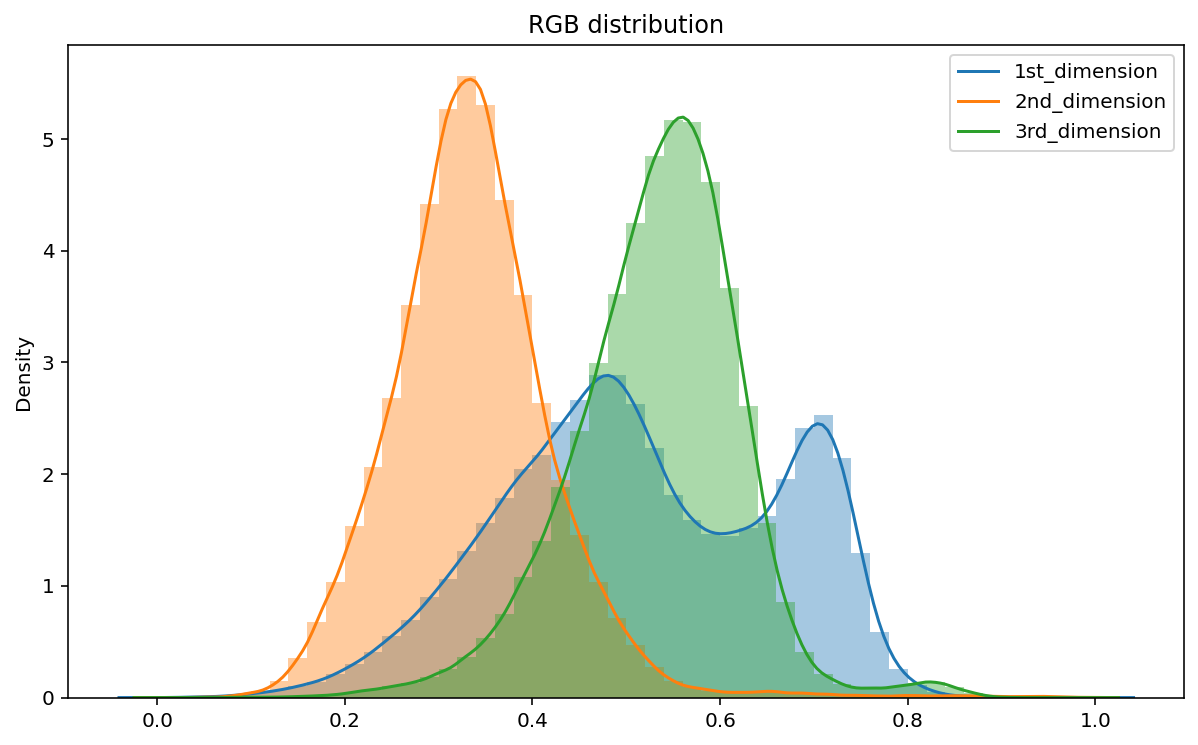

In [ ]:
%config InlineBackend.figure_format ='retina'
g =sns.distplot(rgb_z[:,0]).set_title("RGB distribution")
g =sns.distplot(rgb_z[:,1])
g =sns.distplot(rgb_z[:,2])

plt.legend(labels=['1st_dimension','2nd_dimension','3rd_dimension'])
plt.show(g)


Distributions are quit good ,which is a good indicator of the relevantess of the embedding.

## Visualize the embedding

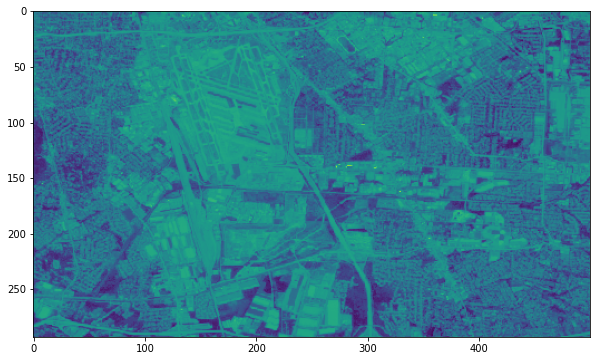

In [56]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.imshow(bands[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


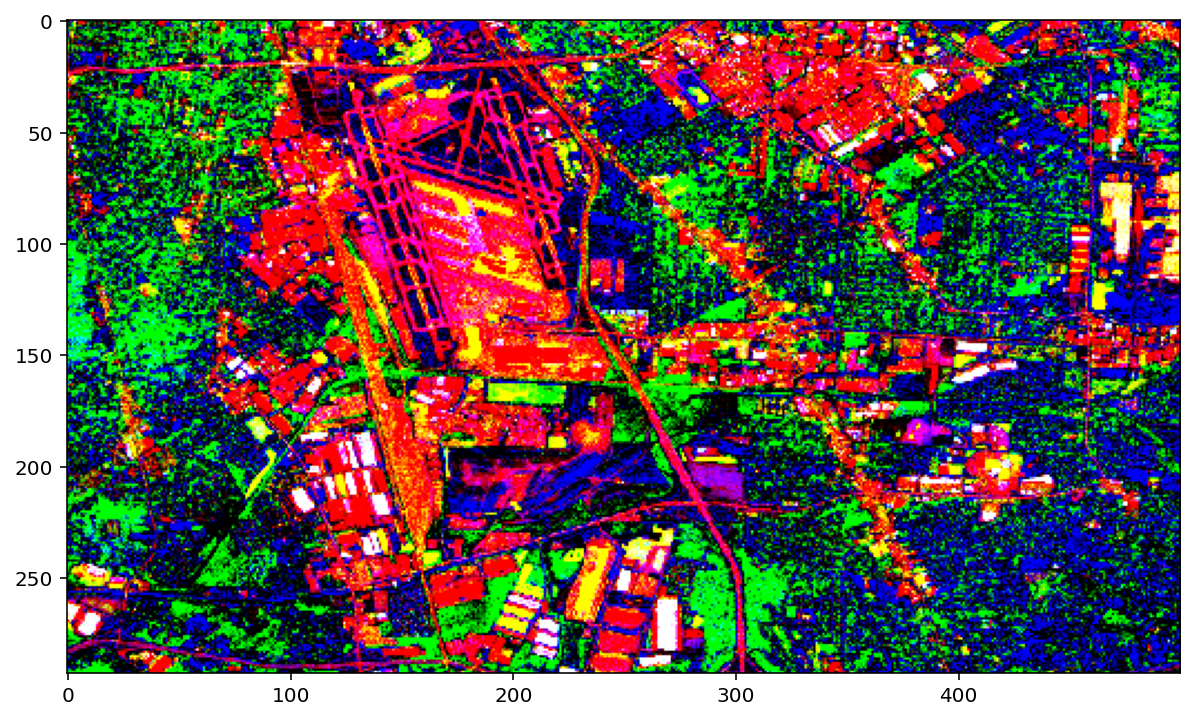

In [ ]:
encoder = variational_autoencoder.embed(data)
compressed = encoder.reshape(293,500,3)
plt.rcParams["figure.figsize"] = (10, 6)
plt.imshow(compressed)